In [65]:
#import tensorflow.keras
import os
from os import listdir
from os.path import isdir, join
import numpy as np
from keras import layers, models, metrics
from subprocess import check_output
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential
from keras.layers import Conv3D,MaxPooling3D,Dense,Flatten,Dropout
from keras.optimizers import Adam,SGD
from keras.callbacks import TensorBoard
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [66]:
feature_sets_path  = os.getcwd()
filename = 'all_targets_1605_5349'
feature_sets_filename = filename + '.npz'
model_filename = filename + '.h5'
#feature_sets_filename = 'all_targets_987_5135_2_classes_2023_9_2_7-48.npz'
#model_filename = 'all_targets_987_5135_2_classes_2023_9_2_7-48_minus_CNN01.h5'

In [67]:
# Load feature sets
feature_sets = np.load(join(feature_sets_path, feature_sets_filename))
print('features :',feature_sets.files)

features : ['x_train', 'y_train', 'x_val', 'y_val', 'x_test', 'y_test']


In [68]:
# Assign feature sets
x_train = feature_sets['x_train']
y_train = feature_sets['y_train']
x_val = feature_sets['x_val']
y_val = feature_sets['y_val']
x_test = feature_sets['x_test']
y_test = feature_sets['y_test']

In [69]:
# Look at tensor dimensions
print('training input shape :',x_train.shape)
print('validation input shape :',x_val.shape)
print('test input shape :',x_test.shape)

training input shape : (106172, 64, 4)
validation input shape : (22733, 64, 4)
test input shape : (22733, 64, 4)


In [70]:
# Sample shape
NUMBER_ROWS = 127
NUMBER_COlUMNS = 64
DEPTH = 4

In [71]:
# CNN for TF expects (batch (lote), height, width, channels)
# So we reshape the input tensors with a "color" channel of ''

x_train = x_train.reshape(int(x_train.shape[0]/(NUMBER_ROWS)),
                          NUMBER_ROWS,
                          NUMBER_COlUMNS,
                          DEPTH,
                          1)
x_val = x_val.reshape(int(x_val.shape[0]/(NUMBER_ROWS)),
                      NUMBER_ROWS,
                      NUMBER_COlUMNS,
                      DEPTH,
                      1)
x_test = x_test.reshape(int(x_test.shape[0]/(NUMBER_ROWS)),
                        NUMBER_ROWS,
                        NUMBER_COlUMNS,
                        DEPTH,
                        1)

print('number of training samples :',x_train.shape[0])
print('number of validation samples :',x_val.shape[0])
print('number of test samples :',x_test.shape[0])

number of training samples : 836
number of validation samples : 179
number of test samples : 179


In [72]:
# Input shape for CNN is size of MFCC of 1 sample
sample_shape = x_test.shape[1:]
print('sample shape :',sample_shape)

sample shape : (127, 64, 4, 1)


In [73]:
# Build model
# Based on: https://www.geeksforgeeks.org/python-image-classification-using-keras/
model = models.Sequential()

# Convolution filters
model.add(layers.Conv3D(filters=8, kernel_size=(3,3,3), kernel_initializer='random_normal', activation='relu', padding = 'same', input_shape=sample_shape, name = 'Conv3D_layer1'))
model.add(layers.MaxPooling3D(pool_size=(2,2,1), name = 'Pooling_layer1'))
model.add(Dropout(0.5))

model.add(Conv3D(filters=8, kernel_size=(3,3,3), kernel_initializer='random_normal', activation='relu', padding = 'same', name = 'Conv3D_layer2'))
model.add(MaxPooling3D(pool_size=(2,2,1), name = 'Pooling_layer2'))
model.add(Dropout(0.5))

model.add(Conv3D(filters=8, kernel_size=(3,3,3), kernel_initializer='random_normal', activation='relu', padding = 'same', name = 'Conv3D_layer3'))
model.add(MaxPooling3D(pool_size=(2,2,1), name = 'Pooling_layer3'))
model.add(Dropout(0.5))

# Classifier
model.add(Flatten())
model.add(Dense(128, kernel_initializer='random_normal', activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, kernel_initializer='random_normal', activation='relu'))
model.add(Dropout(0.5))


# Check Number of Classes Before Training
model.add(Dense(2, activation='sigmoid'))

# Display model
model.layers
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Conv3D_layer1 (Conv3D)          │ (None, 127, 64, 4, 8)  │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Pooling_layer1 (MaxPooling3D)   │ (None, 63, 32, 4, 8)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 63, 32, 4, 8)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv3D_layer2 (Conv3D)          │ (None, 63, 32, 4, 8)   │         1,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Pooling_layer2 (MaxPooling3D)   │ (None, 31, 16, 4, 8)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 31, 16, 4, 8)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv3D_layer3 (Conv3D)          │ (None, 31, 16, 4, 8)   │         1,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Pooling_layer3 (MaxPooling3D)   │ (None, 15, 8, 4, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 15, 8, 4, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 3840)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │       491,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 499,538 (1.91 MB)

 Trainable params: 499,538 (1.91 MB)

 Non-trainable params: 0 (0.00 B)

In [74]:
# PatientEearly Stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20, restore_best_weights=True)
#mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [75]:
# Add training parameters to model
model.compile(loss='sparse_categorical_crossentropy',
             optimizer=keras.optimizers.Adam(learning_rate=0.001), #SGD, RMSProp, Adam, nadam
             loss_weights=0.1,
             metrics=['accuracy'])

In [76]:
# Train
history = model.fit(x_train,
                   y_train,
                   epochs=250,
                   batch_size=8,
                   validation_data=(x_val,y_val),
                   callbacks = [es])

Epoch 1/250
105/105 ━━━━━━━━━━━━━━━━━━━━ 8s 50ms/step - accuracy: 0.5221 - loss: 0.0697 - val_accuracy: 0.4972 - val_loss: 0.0692
Epoch 2/250
105/105 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.6430 - loss: 0.0645 - val_accuracy: 0.9553 - val_loss: 0.0086
Epoch 3/250
105/105 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9539 - loss: 0.0144 - val_accuracy: 0.9385 - val_loss: 0.0163
Epoch 4/250
105/105 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.9860 - loss: 0.0035 - val_accuracy: 1.0000 - val_loss: 3.7957e-05
Epoch 5/250
105/105 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.9992 - loss: 3.2898e-04 - val_accuracy: 1.0000 - val_loss: 6.5984e-05
Epoch 6/250
105/105 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.9968 - loss: 8.3519e-04 - val_accuracy: 1.0000 - val_loss: 1.0344e-05
Epoch 7/250
105/105 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - accuracy: 0.9994 - loss: 3.6992e-04 - val_accuracy: 1.0000 - val_loss: 7.6052e-05
Epoch 8/250
105/105 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - accura

In [77]:
history_14_52 =history

In [78]:
history_14_59 =history

In [79]:
history_15_1 =history

In [80]:
for j in history.history:
    print (j)

accuracy
loss
val_accuracy
val_loss


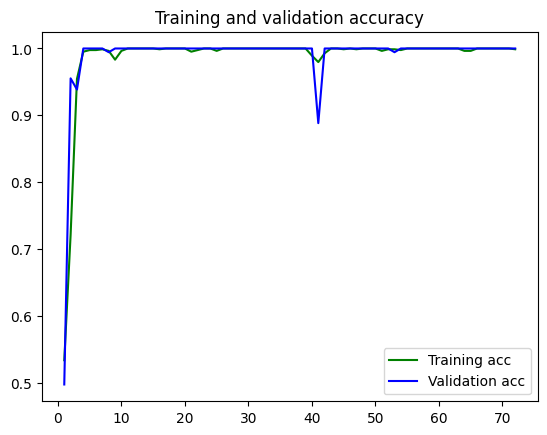

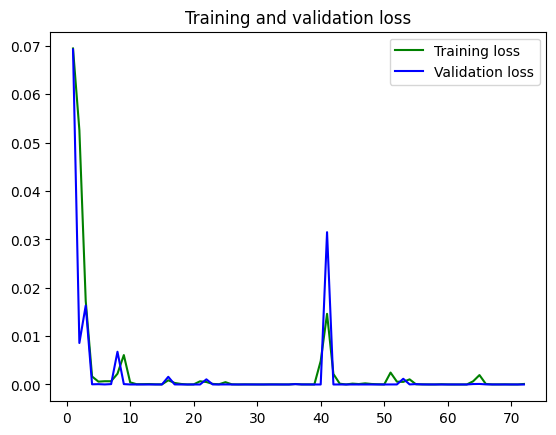

In [81]:
# Plot results
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
#recall = history.history['recall_1']
#val_recall = history.history['val_recall_1']
#precision = history.history['precision']
#val_precision = history.history['val_precision']


epochs = range(1, len(acc) + 1)

# Plot the training and validation accuracy
plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

# Plot the training and validation loss
plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [82]:
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)

6/6 - 0s - 57ms/step - accuracy: 1.0000 - loss: 0.0000e+00


In [83]:
# Save the model as a file
with open(os.getcwd() + '\\file.txt', 'w') as f:
  f.write(os.getcwd())

models.save_model(model, feature_sets_path + '\\' + model_filename)


In [84]:
print('saved model path :',feature_sets_path + '/' + model_filename)

saved model path : c:\Users\Iman\Desktop\Stage\code/all_targets_1605_5349.h5


In [85]:
import seaborn as sns
import tensorflow as tf


In [86]:
y_true=y_train
#y_pred=model.predict_classes(x_test)
predict_y=model.predict(x_train)
y_pred=np.argmax(predict_y,axis=1)

27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step


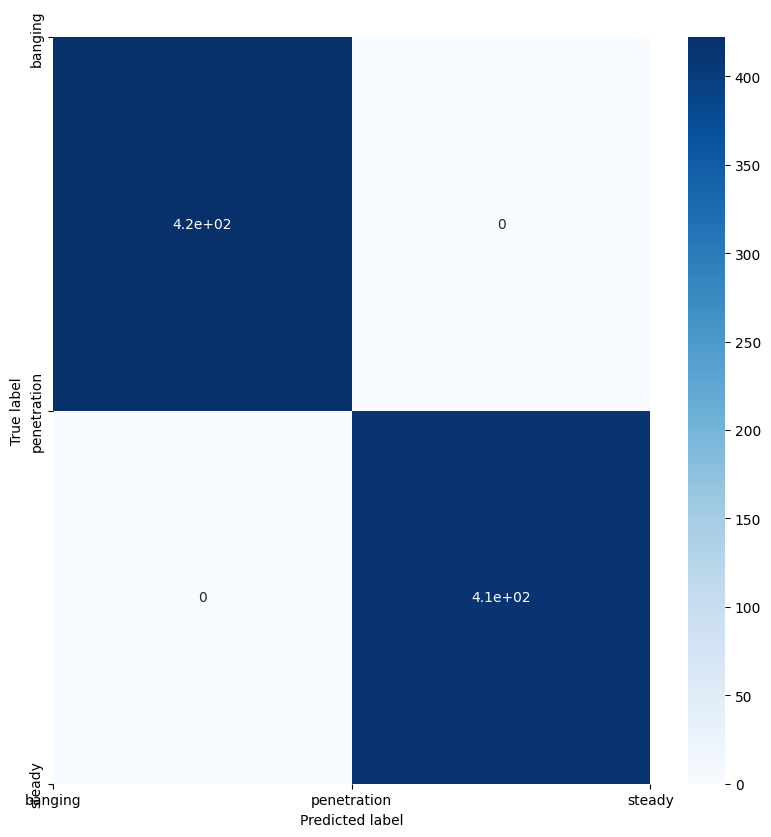

In [87]:
classes = [0,1]
con_mat = tf.math.confusion_matrix(labels=y_true, predictions=y_pred).numpy()
con_mat_norm = np.around(con_mat.astype('float')) #/ con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

con_mat_df = pd.DataFrame(con_mat_norm,
                     index = classes,
                     columns = classes)

figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
#ax = figure.add_axes([0, 6, 0, 6]) # main axes
plt.xticks([0,1,2],['banging', 'penetration','steady'])
plt.yticks([0,1,2],['banging', 'penetration','steady'])
#plt.xticks([0,1,2,3,4,5,6], ['closed', 'drill','opened', 'openingclosing', 'penetration', 'shake', 'shock'], rotation='vertical')
#plt.yticks([0,1,2,3,4,5,6], ['closed', 'drill','opened', 'openingclosing', 'penetration', 'shake', 'shock'], rotation='horizontal')
#ax.set_xlabels(['closed', 'drill','opened', 'openingclosing', 'penetration', 'shake', 'shock'])
#ax.set_xyabels(['closed', 'drill','opened', 'openingclosing', 'penetration', 'shake', 'shock'])
plt.show()

number of samples : 354
test samples shape : (127, 64, 4, 1)
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step
Predicted Class for sample 7 (0-idle, 1-presence) 
0 :  0.9999998 
1 :  0.0055295588


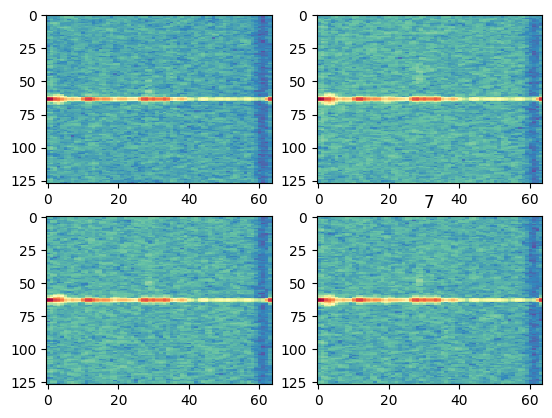

Predicted Class for sample 28 (0-idle, 1-presence) 
0 :  0.99997866 
1 :  0.03866541


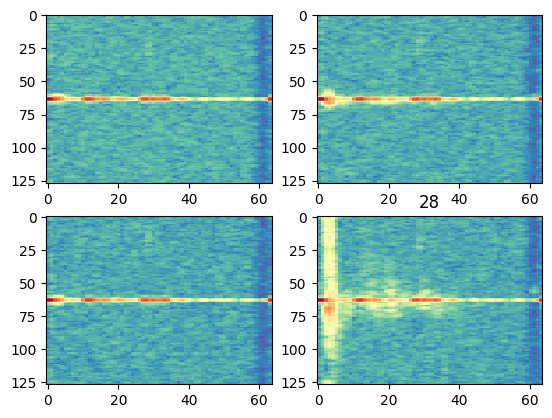

Predicted Class for sample 49 (0-idle, 1-presence) 
0 :  0.9999999 
1 :  0.0044590305


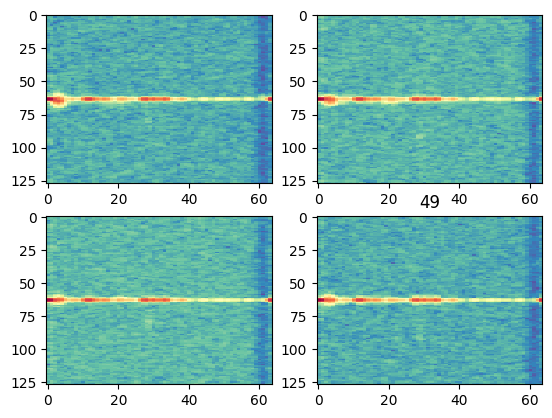

Predicted Class for sample 70 (0-idle, 1-presence) 
0 :  0.99999976 
1 :  0.0058025904


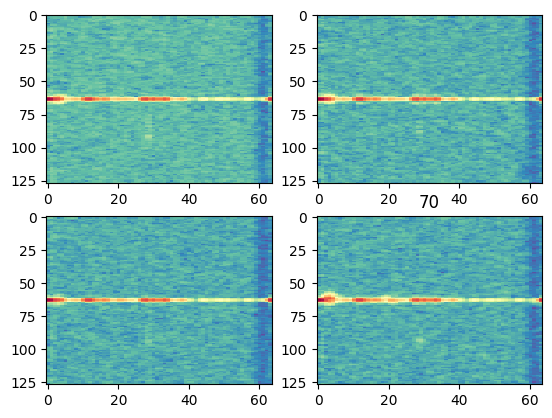

Predicted Class for sample 91 (0-idle, 1-presence) 
0 :  0.9999999 
1 :  0.0042767073


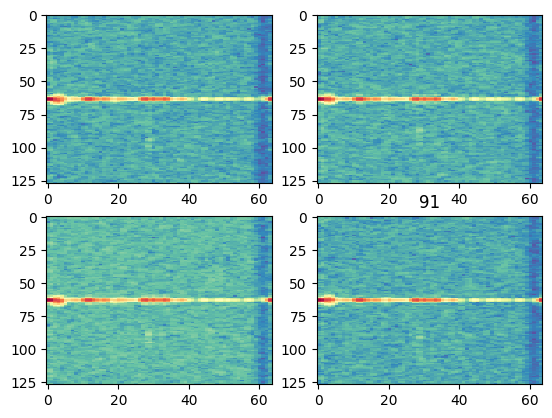

Predicted Class for sample 112 (0-idle, 1-presence) 
0 :  0.9999995 
1 :  0.007469568


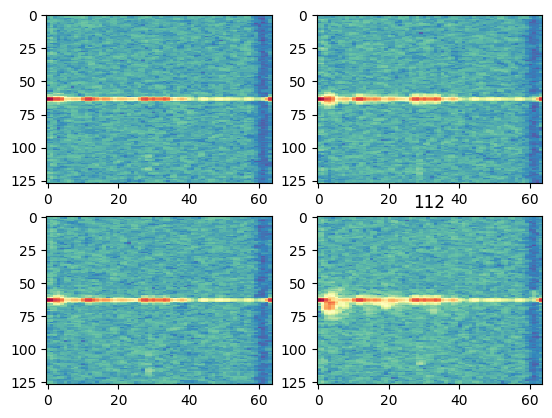

Predicted Class for sample 133 (0-idle, 1-presence) 
0 :  6.565896e-08 
1 :  0.9999999


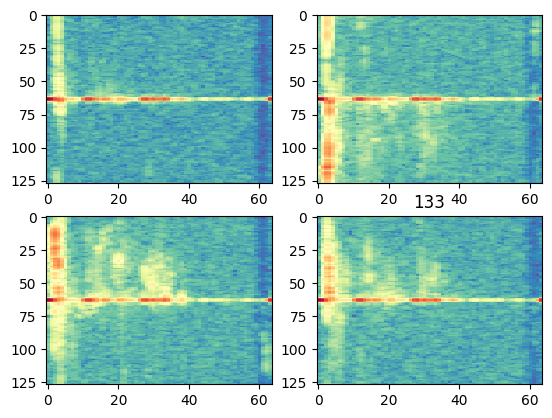

Predicted Class for sample 154 (0-idle, 1-presence) 
0 :  0.99999964 
1 :  0.0066601676


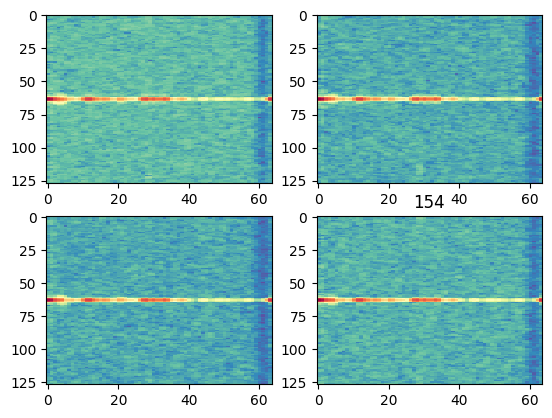

Predicted Class for sample 175 (0-idle, 1-presence) 
0 :  6.203875e-07 
1 :  0.9999991


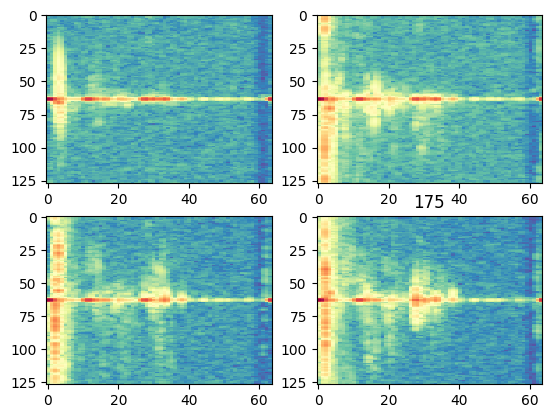

Predicted Class for sample 196 (0-idle, 1-presence) 
0 :  0.81592643 
1 :  0.9252322


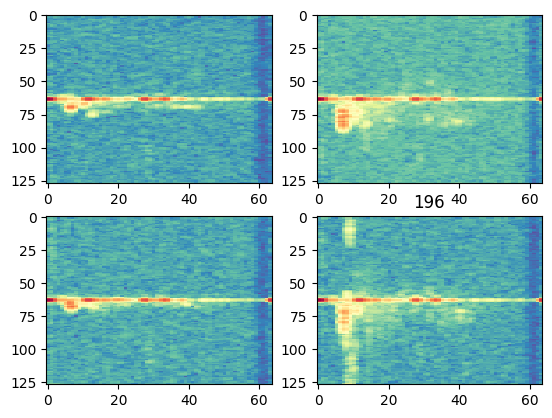

Predicted Class for sample 217 (0-idle, 1-presence) 
0 :  1.0130415e-10 
1 :  1.0


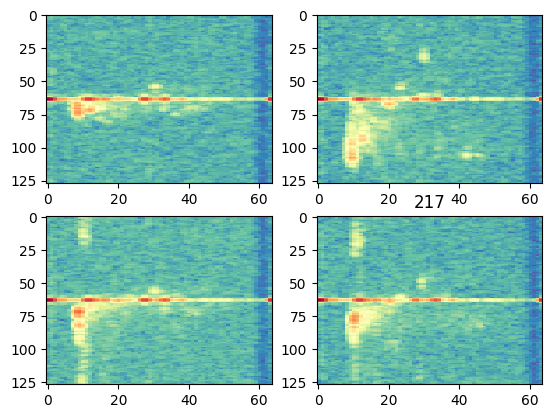

Predicted Class for sample 238 (0-idle, 1-presence) 
0 :  4.6717435e-08 
1 :  0.9999999


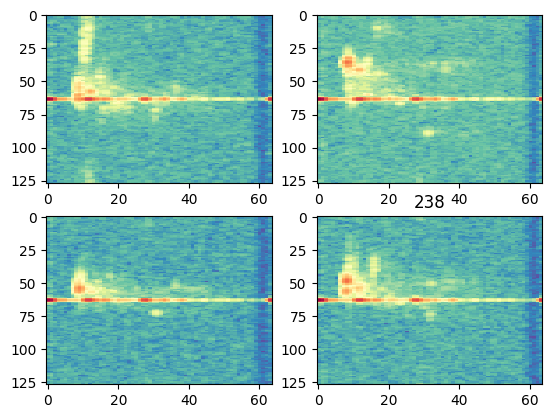

Predicted Class for sample 259 (0-idle, 1-presence) 
0 :  0.0010501461 
1 :  0.99859154


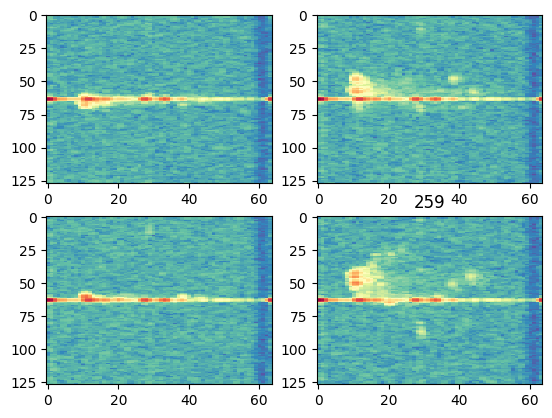

Predicted Class for sample 280 (0-idle, 1-presence) 
0 :  1.5665012e-08 
1 :  0.99999994


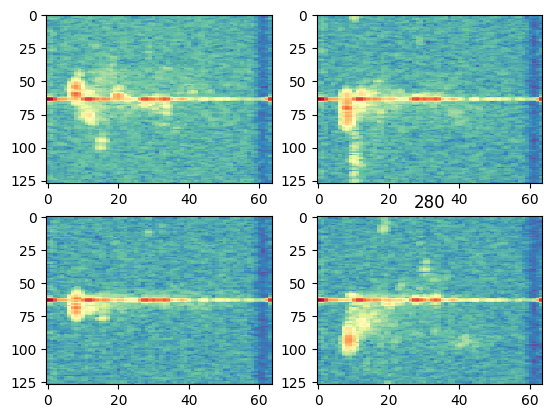

Predicted Class for sample 301 (0-idle, 1-presence) 
0 :  7.096462e-12 
1 :  1.0


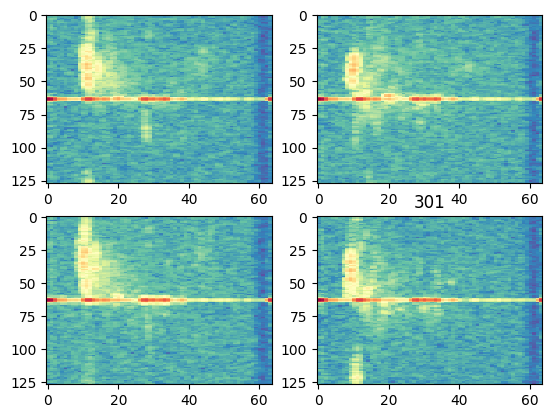

Predicted Class for sample 322 (0-idle, 1-presence) 
0 :  3.1724218e-07 
1 :  0.9999991


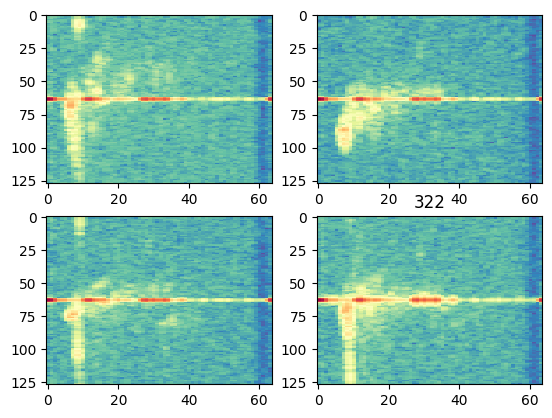

Predicted Class for sample 343 (0-idle, 1-presence) 
0 :  3.9942882e-14 
1 :  1.0


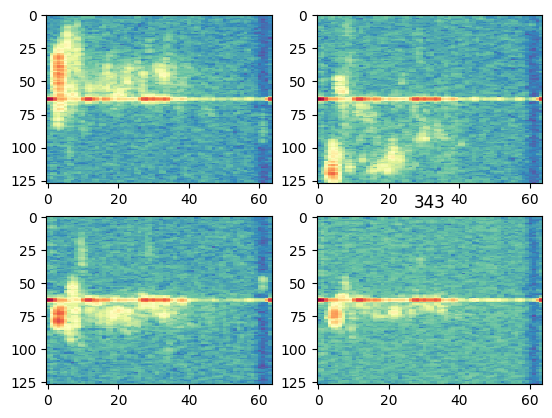

In [88]:
# Prediction test with unclassified parameters

# Load archive with the data to be predicted .npz
test_npz = np.load(os.getcwd()+'\\all_targets_1613_5351_test_classes_360.npz')
test_in = test_npz['x_test']                                  

test_in_reshape = test_in.reshape(int(test_in.shape[0]/(NUMBER_ROWS)),                  # Resize with sample shape
                          NUMBER_ROWS,
                          NUMBER_COlUMNS,
                          DEPTH,
                          1)

print('number of samples :',test_in_reshape.shape[0])
print('test samples shape :',test_in_reshape.shape[1:])

# Prediction on test sample pack
label = model.predict(test_in_reshape)

# Expected predictions on test 60 sample pack
#expected = [1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]

# Loop throught the sample pack to display some of the predictions
for i in range (7,test_in_reshape.shape[0],21):
    print("Predicted Class for sample",i,"(0-idle, 1-presence) \n0 : ",label[i][0],"\n1 : ",label[i][1])    # Print predicted class
    sample = test_in[127*i:127*(i+1),:,:].reshape(
                          NUMBER_ROWS,
                          NUMBER_COlUMNS,
                          DEPTH)
    fig, subs = plt.subplots(2,2)
    for x in range(0,4,1): 
        f = sample[:,:,x]
        # read the csv file
        if (x < 2):
            subs[x][0].imshow(f, cmap='Spectral_r', interpolation='nearest', aspect='auto')
        else:
            subs[x-2][1].imshow(f, cmap='Spectral_r', interpolation='nearest', aspect='auto')
    plt.title(i)
    plt.show()
    #print("Expected prediction : ",expected[i],"\n")
